# Optimizing Parameters with Genetic Algorithms

In [251]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
import numpy as np

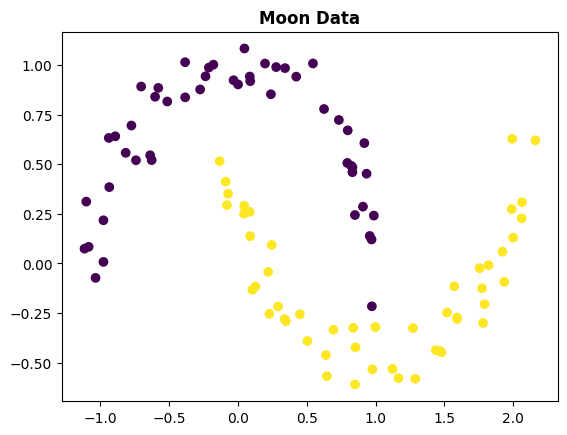

In [8]:
X, y= make_moons(n_samples= 100, noise= 0.1)

plt.scatter(x= X[:, 0], y= X[:, 1], c= y)

plt.title("Moon Data", weight= 'bold')
plt.show()

In [253]:
MUTATE_RATE= 0.1    # Learning Rate
MUTATE_RNG= 0.5
POLYNOMIAL_DEGRE= 6

# Data Preprocessing
X_data= PolynomialFeatures(degree= POLYNOMIAL_DEGRE, include_bias= False).fit_transform(X)

### GAs from Scratch

In [254]:
def create_cell(parent1, parent2):
    """
        Auxiliary Functions to create an individual        
    """
    if parent1 is None or parent2 is None:
        return {
            'fitness': 0,
            'weights': np.random.normal(scale= 1 / np.sqrt(2), size= [X_data.shape[-1], 1]),
            'bias': np.random.normal(size= [1, 1])
        }
    else:
        return {
            'fitness': 0,
            'weights': (parent1['weights'] + parent2['weights']) / 2,
            'bias': (parent1['bias'] + parent2['bias']) / 2,
        }

def birth(offspring):
    """
        Build the population.
                offsptring. int value
    """
    return [create_cell(None, None) for _ in range(offspring)]

def model(X, weights, bias):
    """
        Compute the Logistic Regression output
            X. input data, (n_samples, n_columns)
            weights. logistic regression weights (n_features, n_units)
            bias. logistic regression bias
    """
    x= X.dot(weights) + bias
    return (1 / (1 + np.exp(-x))).reshape(-1)

def loss_function(y_true, y_pred, epsilon= 1e-10):
    """
        Compute the Loss usign the Binary Cross Entropy
            y_true. true labels
            y_pred. predicted labels
    """
    cross_entropy= y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon)
    return np.mean(cross_entropy)

def evaluate(X, y, cells):
    """
        Compute the fitness for each individual, which is the loss for each individual's parameters
            X. input data
            y. labels
            cells. a list of dictionaries representing each individual.
    """
    for cell in cells:
        y_pred= model(X, cell['weights'], cell['bias'])
        cell['fitness']= loss_function(y, y_pred)
    return cells

def mutate(cells):
    """
        Function to mutate the cells
    """
    for cell in cells:
        if np.random.rand() < MUTATE_RATE:
            cell["weights"] += np.random.uniform(low= -MUTATE_RNG, high= MUTATE_RNG, size= [X_data.shape[-1], 1]) 
            cell["bias"] += np.random.uniform(low= -MUTATE_RNG, high= MUTATE_RNG, size= [1, 1])
    return cells

def reproduce(cells):
    """
        Function to create more individuals based on the best current individuals 
    """
    parents= sorted(cells, key= lambda d: d['fitness'])[int(len(cells)/2):]
    children= []
    for i in range(len(parents) * 2):
        mates= np.random.choice(parents, size= 2, replace= False)
        children.append(create_cell(mates[0], mates[1]))
    return mutate(children)

def run_generation(cells):
    cells= evaluate(X_data, y, cells)
    cells= reproduce(cells)
    cells= evaluate(X_data, y, cells)
    return cells

In [255]:
epochs= 100
offspring= 100

# Build population
cells= birth(offspring)

history= {'population': [], 'loss': []}
for i in range(1, epochs + 1):
    cells= run_generation(cells)
    history['population'].append(len(cells))
    history['loss'].append(sum([cell['fitness'] for cell in cells]) / -len(cells))

    print(f"Iteration: {i} -- Loss: {history['loss'][-1]}")

Iteration: 1 -- Loss: 0.7586570614907976
Iteration: 2 -- Loss: 0.5352940006380491
Iteration: 3 -- Loss: 0.4658842719983881
Iteration: 4 -- Loss: 0.43953824566998956
Iteration: 5 -- Loss: 0.4343650154363208
Iteration: 6 -- Loss: 0.4091931161304181
Iteration: 7 -- Loss: 0.39728890664564454
Iteration: 8 -- Loss: 0.40370241161190523
Iteration: 9 -- Loss: 0.38240913159440754
Iteration: 10 -- Loss: 0.38857094772439227
Iteration: 11 -- Loss: 0.3746642333853407
Iteration: 12 -- Loss: 0.36044850414692303
Iteration: 13 -- Loss: 0.3548639921964279
Iteration: 14 -- Loss: 0.36991746160684236
Iteration: 15 -- Loss: 0.33727449919003516
Iteration: 16 -- Loss: 0.3267692130032156
Iteration: 17 -- Loss: 0.3600036541349681
Iteration: 18 -- Loss: 0.3393599797101852
Iteration: 19 -- Loss: 0.3311910084006615
Iteration: 20 -- Loss: 0.3293648998618647
Iteration: 21 -- Loss: 0.2931164977633632
Iteration: 22 -- Loss: 0.30346944586957625
Iteration: 23 -- Loss: 0.295439561538237
Iteration: 24 -- Loss: 0.2783012104

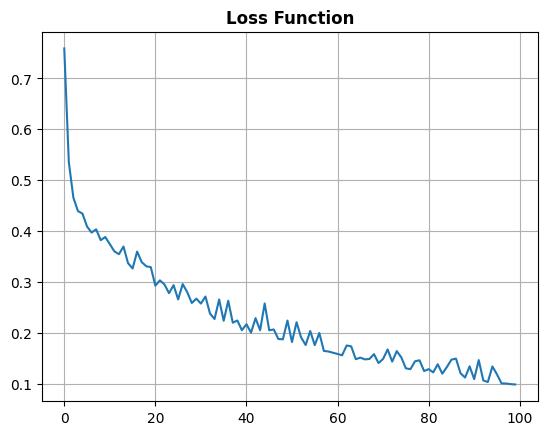

In [256]:
plt.plot(history['loss'])

plt.title("Loss Function", weight= "bold")
plt.grid(True)
plt.show()

In [257]:
best_ind= 0
min_loss= 1e1

for i, cell in enumerate(cells):
    current_loss= loss_function(y, model(X_data, cell['weights'], cell['bias']))
    if current_loss < min_loss:
        min_loss= current_loss
        best_ind= i

best_w, best_b= cells[i]['weights'], cells[i]['bias'] 

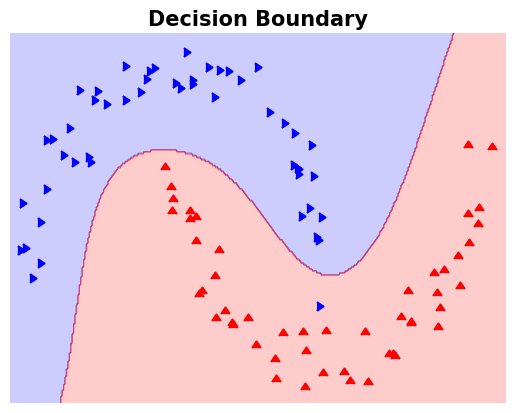

In [258]:
# Select Best Weights
X_set, y_set= X_data, y

X1, X2= np.meshgrid(np.arange(X_set[:, 0].min() - 0.1, X_set[:, 0].max() + 0.1, 0.01),
                   np.arange(X_set[:, 1].min() - 0.1, X_set[:, 1].max() + 0.1, 0.01))
X_grid= PolynomialFeatures(degree= POLYNOMIAL_DEGRE, include_bias= False).fit_transform(np.c_[X1.ravel(), X2.ravel()])
Z= model(X_grid, best_w, best_b).reshape(X1.shape)
Z= np.where(Z > 0.5, 1, 0)

plt.contourf(X1, X2, Z, cmap= ListedColormap(('blue', 'red')), alpha= 0.2)

for i, label in enumerate(np.unique(y)):
    plt.scatter(x= X_set[label == y, 0], y= X_set[label == y, 1], color= ListedColormap(('blue', 'red'))(i), marker= 5 + i, s= 40)

plt.title("Decision Boundary", weight= 'bold', fontsize= 15)
plt.axis(False)
plt.show()

In [11]:
# Compute the accuracy
y_pred= (model(X_data, best_w, best_b) > 0.5).astype(int).reshape(-1)

accuracy= np.mean(np.equal(y_pred, y))

print(accuracy)

0.98


### With DEAP Library

In [1]:
%pip install deap

     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.1 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.1 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.1 MB ? eta -:--:--
     --- ------------------------------------ 0.1/1.1 MB 525.1 kB/s eta 0:00:02
     ------- -------------------------------- 0.2/1.1 MB 841.6 kB/s eta 0:00:02
     ------------------------ --------------- 0.6/1.1 MB 2.4 MB/s eta 0:00:01
     ---------------------------------------- 1.1/1.1 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for deap: filename=deap-1.4.1-cp311-cp311-win_amd64.whl size=108909 sha256=cdfba373368cca332c2480427b3a90f7cd1b51ad0a23da3c3654ab4d6ea204c9
  Stored in directory: c:\users\angcr\appdata\local\pip\cache\wheels\f8\64\b8\65eacfbff3024ae2e2beb22e691d5c8abb89fbd863b8049b5f
Successfully 

In [195]:
from deap import algorithms
from deap import tools
from deap import creator
from deap import base

import numpy as np
import random

In [211]:
def init_weights():
    """
        Initialize weights and bias
    """
    return {
        "weights": np.random.normal(size= [X_data.shape[-1], 1]),
        "bias": np.zeros(shape= [1, 1])
    }


def evalLoss(individual):
    weights= individual['weights']
    bias= individual['bias']
    # model function to compute the dot-product
    preds= model(X_data, weights, bias)
    # compute loss with the 'loss_function'
    loss= loss_function(y, preds)
    return loss,

def new_children(parent1, parent2) -> list:
    return {
            'weights': (parent1['weights'] + parent2['weights']) / 2,
            'bias': (parent1['bias'] + parent2['bias']) / 2,
        }

def crossover(ind1, ind2):
    children= []
    for i in range(2):
        children.append(new_children(ind1, ind2))
    return (children[0], children[1])

def mutation(individual, MUTATE_RNG= 0.5):
    individual["weights"] += np.random.uniform(low= -MUTATE_RNG, high= MUTATE_RNG, size= [X_data.shape[-1], 1]) 
    individual["bias"] += np.random.uniform(low= -MUTATE_RNG, high= MUTATE_RNG, size= [1, 1])
    return individual

In [212]:
# Create the structure for the individual
creator.create("FitnessMax", base.Fitness, weights= (1.0,))
creator.create("Individual", dict, fitness= creator.FitnessMax)

In [213]:
toolbox= base.Toolbox()

toolbox.register("individual", tools.initIterate, creator.Individual, init_weights)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [214]:
# Define Classes
toolbox.register("evaluate", evalLoss)
toolbox.register("mate", crossover)
toolbox.register("mutation", mutation, MUTATE_RNG= 0.5)
toolbox.register("select", tools.selTournament, tournsize= 3)

In [235]:
MUTATION_RATE= 0.1
# Initialize Population
pop= toolbox.population(n= 100)
# Evaluate Fitness
fitness= list(map(toolbox.evaluate, pop))
# Assign fitnesses to each individual
for ind, fit in zip(pop, fitness):
    ind.fitness.values= fit
# Store fitnesses in a list
fits= [ind.fitness.values[0] for ind in pop]

# Main Loop
epoch= 0
while epoch < 100 and max(fits) < -0.1:
    epoch += 1
    print("Generation {}".format(epoch))
    # Select individuals (Tournament)
    offspring= toolbox.select(pop, len(pop))
    # Clone the individuals
    offspring= [toolbox.clone(ind) for ind in offspring]
    
    # Apply crossover and mutation
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if np.random.uniform(0, 1) < 0.5:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values    
    for ind in offspring:
        if np.random.uniform(0, 1) < MUTATION_RATE:
            toolbox.mutation(ind)
            del ind.fitness.values
    
    # Evaluate individuals with invalid fitness
    invalid_ind= [ind for ind in offspring if not ind.fitness.valid]
    fitness= list(map(toolbox.evaluate, invalid_ind))
    for ind, fit in zip(invalid_ind, fitness):
        ind.fitness.values= fit
    # Replace Population with the new one
    pop[:]= offspring

    # Gather all the fitnesses and print stats
    fits= [ind.fitness.values[0] for ind in pop]

    print(f"""
        Max: {max(fits)}
        Min: {min(fits)}
        Mean: {np.mean(fits)}
        Std: {np.std(fits)}
    """)

Generation 1

        Max: -0.33961495776785766
        Min: -5.056139169573937
        Mean: -1.1555891611157638
        Std: 0.9808370448680438
    
Generation 2

        Max: -0.33961495776785766
        Min: -1.6322792685869083
        Mean: -0.5637626726834529
        Std: 0.2538115714110551
    
Generation 3

        Max: -0.2818902056626612
        Min: -1.020144545518037
        Mean: -0.39474580995401676
        Std: 0.09716468148377186
    
Generation 4

        Max: -0.2818902056626612
        Min: -0.9860429821559115
        Mean: -0.36312688107964236
        Std: 0.10152025708924896
    
Generation 5

        Max: -0.2745533076931476
        Min: -0.3842912553382032
        Mean: -0.329685795831579
        Std: 0.027167509611408028
    
Generation 6

        Max: -0.23206368290286966
        Min: -0.3466865482108513
        Mean: -0.3035216356991014
        Std: 0.02765037712800495
    
Generation 7

        Max: -0.23206368290286966
        Min: -0.3820218138508811
      

In [247]:
# Get the Best Individual
ind_idx = fits.index(max(fits))

weights, biases= pop[ind_idx].values()

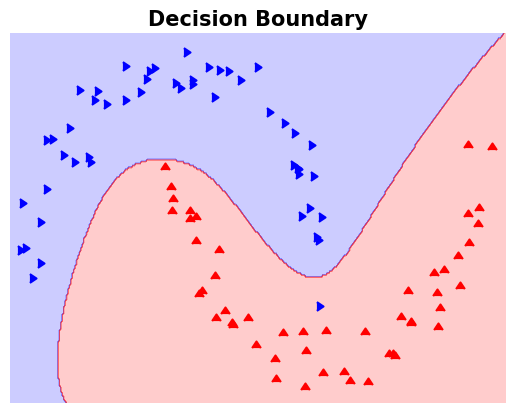

In [252]:
# Select Best Weights
X_set, y_set= X_data, y

X1, X2= np.meshgrid(np.arange(X_set[:, 0].min() - 0.1, X_set[:, 0].max() + 0.1, 0.01),
                   np.arange(X_set[:, 1].min() - 0.1, X_set[:, 1].max() + 0.1, 0.01))
X_grid= PolynomialFeatures(degree= POLYNOMIAL_DEGRE, include_bias= False).fit_transform(np.c_[X1.ravel(), X2.ravel()])
Z= model(X_grid, weights, biases).reshape(X1.shape)
Z= np.where(Z > 0.5, 1, 0)

plt.contourf(X1, X2, Z, cmap= ListedColormap(('blue', 'red')), alpha= 0.2)

for i, label in enumerate(np.unique(y)):
    plt.scatter(x= X_set[label == y, 0], y= X_set[label == y, 1], color= ListedColormap(('blue', 'red'))(i), marker= 5 + i, s= 40)

plt.title("Decision Boundary", weight= 'bold', fontsize= 15)
plt.axis(False)
plt.show()